In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm

In [5]:

def policy(matrix, weight):
    """Computes a policy using the given weight matrix.
    Args:
        matrix: a state matrix
        weight: a weight matrix
    Returns:
        the policy"""

    exponentiated_matrix = np.exp(matrix.dot(weight))
    policy_values = exponentiated_matrix / \
        np.sum(exponentiated_matrix, axis=1, keepdims=True)

    return policy_values

In [3]:
weight = np.ndarray((4, 2), buffer=np.array([
    [4.17022005e-01, 7.20324493e-01],
    [1.14374817e-04, 3.02332573e-01],
    [1.46755891e-01, 9.23385948e-02],
    [1.86260211e-01, 3.45560727e-01]
]))
state = np.ndarray((1, 4), buffer=np.array([
    [-0.04428214,  0.01636746,  0.01196594, -0.03095031]
]))

res = policy(state, weight)
print(res)

[[0.50351642 0.49648358]]


In [6]:
"""Task 1: Compute the Monte-Carlo Policy Gradient"""


def policy_gradient(state, weight):
    """computes the Monte-Carlo policy gradient based on a
    state and a weight matrix.
    Args:
        state: matrix representing the current observation of the environment
        weight: matrix of random weight
    Returns:
        the action and the gradient (in this order)"""

    # get action prob. dist. from policy
    actions = policy(state, weight)
    # get action based on prob. dist.
    action = np.random.choice(len(actions[0]), p=actions[0])
    # reshaping to fit softmax
    s = actions.reshape(-1, 1)
    # apply softmax function to s and access value at action
    softmax = (np.diagflat(s) - np.dot(s, s.T))[action, :]
    # calculate the derivative of log as softmax / policy at action
    dlog = softmax / actions[0, action]
    # find gradient from input state matrix using dlog
    gradient = state.T.dot(dlog[None, :])
    # return action and the policy gradient
    return action, gradient

In [5]:
env = gym.make('CartPole-v1')
np.random.seed(1)

weight = np.random.rand(4, 2)
state = env.reset()[None, :]
print(weight)
# state = np.array(state[0]).reshape(1, -1)
# state = np.array([[0.04228739, -0.04522399,  0.01190918, -0.03496226]])
print(state)

action, grad = policy_gradient(state, weight)
print(action)
print(grad)

env.close()

[[4.17022005e-01 7.20324493e-01]
 [1.14374817e-04 3.02332573e-01]
 [1.46755891e-01 9.23385948e-02]
 [1.86260211e-01 3.45560727e-01]]
[[-0.03926622 -0.02868273 -0.02334112  0.00250083]]
0
[[-0.01944749  0.01944749]
 [-0.01420578  0.01420578]
 [-0.01156022  0.01156022]
 [ 0.00123859 -0.00123859]]


/home/ediddev/anaconda3/lib/python3.11/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/ediddev/anaconda3/lib/python3.11/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [48]:
def train(env, nb_episodes, alpha=0.00005, gamma=0.99):
    """Performs full Training using policy gradient.
    Args:
        env: initial environment
        nb_episodes: number of episodes used for training
        alpha: the learning rate
        gamma: the discount factor
    Returns:
        all_scores: all values of the scores (sum of rewards during one loop)
    """

    # initialize weight randomly based on given environment
    n_obs = env.observation_space.shape[0]
    n_actions = env.action_space.n
    weight = np.random.rand(n_obs, n_actions)
    # to track scores of episodes
    all_scores = []
    # iterate over all episodes
    for episode in range(nb_episodes):
        state = env.reset()[None, :]
        gradients = []
        rewards = []
        sum_rewards = 0
        while True:
            # get action and gradient from policy_gradient function
            action, gradient = policy_gradient(state, weight)
            # use action to determine next state, reward, done
            next_state, reward, done, _ = env.step(action)
            # append gradient and reward to repective lists
            gradients.append(gradient)
            rewards.append(reward)
            # add the reward to the episode score
            sum_rewards += reward
            # if done, breaks the loop
            if done:
                break
            # else the state is reset to the next state
            state = next_state[None, :]

        # for each step in the episode, compute the discounted sum of rewards
        # and update the weights accordingly
        for i in range(len(gradients)):
            weight += (alpha * gradients[i]) * \
                (gamma ** np.array(rewards[i:]) * np.array(rewards[i:])).sum()

        # append the episode's score to all_scores
        all_scores.append(sum_rewards)

        if episode % 500 == 0:
            print(f"Episode: {episode} --- Reward: {sum_rewards}")

    # return all values of scores
    return all_scores

Episode: 0 --- Reward: 16.0
Episode: 500 --- Reward: 48.0
Episode: 1000 --- Reward: 78.0
Episode: 1500 --- Reward: 95.0
Episode: 2000 --- Reward: 227.0
Episode: 2500 --- Reward: 367.0
Episode: 3000 --- Reward: 500.0
Episode: 3500 --- Reward: 500.0
Episode: 4000 --- Reward: 500.0
Episode: 4500 --- Reward: 500.0
Episode: 5000 --- Reward: 500.0
Episode: 5500 --- Reward: 394.0
Episode: 6000 --- Reward: 433.0
Episode: 6500 --- Reward: 500.0
Episode: 7000 --- Reward: 500.0
Episode: 7500 --- Reward: 500.0
Episode: 8000 --- Reward: 500.0
Episode: 8500 --- Reward: 500.0
Episode: 9000 --- Reward: 500.0
Episode: 9500 --- Reward: 500.0


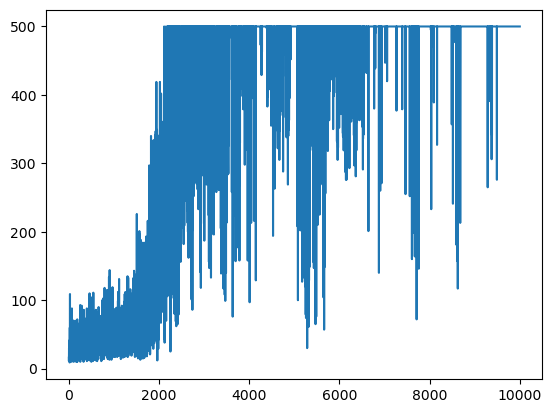

In [49]:
env = gym.make('CartPole-v1')

scores = train(env, 10000)

plt.plot(np.arange(len(scores)), scores)
plt.show()
env.close()

In [58]:
import pandas as pd
df = pd.DataFrame(scores)
print(df.describe())
print()
print(df.value_counts())

                  0
count  10000.000000
mean     387.575700
std      179.749887
min        9.000000
25%      300.000000
50%      500.000000
75%      500.000000
max      500.000000

500.0    6429
43.0       44
39.0       41
31.0       38
27.0       37
         ... 
331.0       1
333.0       1
381.0       1
412.0       1
254.0       1
Length: 483, dtype: int64


In [13]:
def train1(env, nb_episodes, alpha=0.00005, gamma=0.99, show_result=True):
    """Performs full Training using policy gradient.
    Args:
        env: initial environment
        nb_episodes: number of episodes used for training
        alpha: the learning rate
        gamma: the discount factor
        show_result: boolean to show result of training every 1000 episodes
    Returns:
        all_scores: all values of the scores (sum of rewards during one loop)
    """

    # initialize weight randomly based on given environment
    n_obs = env.observation_space.shape[0]
    n_actions = env.action_space.n
    weight = np.random.rand(n_obs, n_actions)
    # to track scores of episodes
    all_scores = []
    # iterate over all episodes
    for episode in tqdm(range(nb_episodes)):
        state = env.reset()[None, :]
        gradients = []
        rewards = []
        sum_rewards = 0
        while True:
            # get action and gradient from policy_gradient function
            action, gradient = policy_gradient(state, weight)
            # use action to determine next state, reward, done
            next_state, reward, done, _ = env.step(action)
            # append gradient and reward to repective lists
            gradients.append(gradient)
            rewards.append(reward)
            # add the reward to the episode score
            sum_rewards += reward
            # if done, breaks the loop
            if done:
                break
            # else the state is reset to the next state
            state = next_state[None, :]

        # for each step in the episode, compute the discounted sum of rewards
        # and update the weights accordingly
        for i in range(len(gradients)):
            weight += (alpha * gradients[i]) * \
                (gamma ** np.array(rewards[i:]) * np.array(rewards[i:])).sum()

        # append the episode's score to all_scores
        all_scores.append(sum_rewards)

        if episode % 500 == 0:
            print(f"Episode: {episode} --- Reward: {sum_rewards}")
        if episode % 1000 == 0 and episode >= 1000:
            print(f"Episode: {episode} --- Reward: {sum_rewards}")
            if show_result:
                state = env.reset()[None, :]
                while True:
                    env.render(mode='human')
                    action, _ = policy_gradient(state, weight)
                    next_state, reward, done, _ = env.step(action)
                    state = next_state[None, :]
                    if done:
                        break
    # return all values of scores
    return all_scores

In [14]:
env = gym.make('CartPole-v1')

scores = train1(env, 10000, 0.000045, 0.98, True)

env.close()

/home/ediddev/anaconda3/lib/python3.11/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/ediddev/anaconda3/lib/python3.11/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


  0%|          | 0/10000 [00:00<?, ?it/s]

/home/ediddev/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 0 --- Reward: 15.0
Episode: 500 --- Reward: 45.0
Episode: 1000 --- Reward: 27.0
Episode: 1000 --- Reward: 27.0


/home/ediddev/anaconda3/lib/python3.11/site-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Episode: 1500 --- Reward: 190.0
Episode: 2000 --- Reward: 500.0
Episode: 2000 --- Reward: 500.0
Episode: 2500 --- Reward: 476.0
Episode: 3000 --- Reward: 500.0
Episode: 3000 --- Reward: 500.0
Episode: 3500 --- Reward: 500.0
Episode: 4000 --- Reward: 500.0
Episode: 4000 --- Reward: 500.0
Episode: 4500 --- Reward: 500.0
Episode: 5000 --- Reward: 500.0
Episode: 5000 --- Reward: 500.0
Episode: 5500 --- Reward: 500.0
Episode: 6000 --- Reward: 500.0
Episode: 6000 --- Reward: 500.0
Episode: 6500 --- Reward: 500.0
Episode: 7000 --- Reward: 500.0
Episode: 7000 --- Reward: 500.0
Episode: 7500 --- Reward: 500.0
Episode: 8000 --- Reward: 500.0
Episode: 8000 --- Reward: 500.0
Episode: 8500 --- Reward: 500.0
Episode: 9000 --- Reward: 500.0
Episode: 9000 --- Reward: 500.0
Episode: 9500 --- Reward: 500.0


In [8]:
from tqdm.notebook import tqdm